In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

# Scanning Astra evaluations

In [2]:
from astra import evaluate_astra_with_distgen

import matplotlib.pyplot as plt

import numpy as np
import os

In [3]:
# Input files
ASTRA_IN = 'templates/dcgun/astra.in'
DISTGEN_IN = 'templates/dcgun/distgen.yaml'

In [4]:
# Run Astra with Distgen

# Basic settings
settings0 = {'zstop':1, 'zemit':10, 'zphase':10, 'phases':True}
settings0['distgen:n_particle'] = 2000

# Solenoid field
settings0['maxb(1)'] = 0.04

In [5]:
# This is the basic function we will use
outputs = evaluate_astra_with_distgen(settings0, astra_input_file=ASTRA_IN,
                              distgen_input_file=DISTGEN_IN)
outputs

{'error': False,
 'end_mean_z': 1.0,
 'end_mean_t': 4.0156e-09,
 'end_mean_x': 3.8064000000000004e-11,
 'end_sigma_x': 0.00034241,
 'end_sigma_xp': 0.00058502,
 'end_norm_emit_x': 1.7516999999999997e-07,
 'end_cov_x__xp': 1.72026784e-07,
 'end_mean_y': 2.2886e-10,
 'end_sigma_y': 0.00034245,
 'end_sigma_yp': 0.0005843,
 'end_norm_emit_y': 1.7454e-07,
 'end_cov_y__yp': 1.719818145e-07,
 'end_mean_kinetic_energy': 499790.0,
 'end_sigma_z': 3.4217e-05,
 'end_sigma_energy': 1.055,
 'end_norm_emit_z': 1.9577e-05,
 'end_cov_z__energy': 3.03299488e-05,
 'end_n_particle_loss': 0,
 'end_total_charge': 9.999999999999999e-11,
 'end_higher_order_energy_spread': 0.331557454122008,
 'fingerprint': 'fe128b0d97972679467e59429ff441d0'}

In [6]:
# Make a bare minimum function to evaluate
def f(b):
    s = settings0.copy()
    s['maxb(1)'] = b
    return evaluate_astra_with_distgen(s, astra_input_file=ASTRA_IN,
                          distgen_input_file=DISTGEN_IN)
# Make a list to scan
blist = np.linspace(0, 0.1, 20)
f(0)

{'error': False,
 'end_mean_z': 1.0,
 'end_mean_t': 4.0156e-09,
 'end_mean_x': 1.3338e-10,
 'end_sigma_x': 0.0006159000000000001,
 'end_sigma_xp': 0.0006566,
 'end_norm_emit_x': 1.7485e-07,
 'end_cov_x__xp': 3.9120736200000003e-07,
 'end_mean_y': 2.2689e-10,
 'end_sigma_y': 0.00061615,
 'end_sigma_yp': 0.0006571200000000001,
 'end_norm_emit_y': 1.7485e-07,
 'end_cov_y__yp': 3.917050395e-07,
 'end_mean_kinetic_energy': 499790.0,
 'end_sigma_z': 3.4213e-05,
 'end_sigma_energy': 1.055,
 'end_norm_emit_z': 1.9608e-05,
 'end_cov_z__energy': 3.030553327e-05,
 'end_n_particle_loss': 0,
 'end_total_charge': 9.999999999999999e-11,
 'end_higher_order_energy_spread': 0.3334254975080573,
 'fingerprint': '4c535bdef1cb8c12dfcb3d3794482c2a'}

In [7]:
# Get a parallel executor

# Processes. These lines are needed to get this to work on macOS
import multiprocessing as mp                                                                                     
mp.set_start_method("fork")    
from concurrent.futures import ProcessPoolExecutor as Executor

#from concurrent.futures import ThreadPoolExecutor as Executor # DO NOT USE
#from dask.distributed import Client as Executor

executor=Executor()

In [8]:
# Make a map object. Note that this does not execute immediately.
results = executor.map(f, blist)

In [9]:
# Actually evalute the funciton and gather the results
outputs = []
for r in results:
    outputs.append(r)
#    outputs.append(r.result())

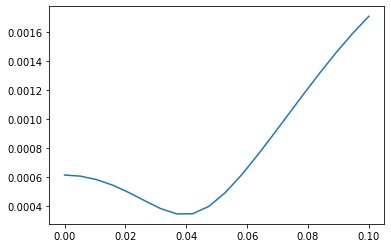

In [10]:
# Simple plot
plt.plot(blist, [o['end_sigma_x'] for o in outputs])

# Better: robust evaluation, form dataset 

In [11]:
from tempfile import TemporaryDirectory
SCRATCH=TemporaryDirectory()

In [12]:
# Make a robust evaluate
def evaluate(b):
    try:
        s = settings0.copy()
        s['maxb(1)'] = b
        output = evaluate_astra_with_distgen(s, astra_input_file=ASTRA_IN,
                              distgen_input_file=DISTGEN_IN, archive_path=SCRATCH.name)
        # Add the input
        output['maxb(1)'] = b
        output['Exception'] = False
    except:
        output = {}
        output['maxb(1)'] = b
        output['Exception'] = True
        
    return output

In [13]:
SCRATCH.name

'/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpgjp7legb'

In [14]:
# This will cause a crash in Astra
evaluate(1e9)

Run Aborted Traceback (most recent call last):
  File "/Users/chrisonian/Code/GitHub/lume-astra/astra/astra.py", line 302, in run_astra
    self.load_output()
  File "/Users/chrisonian/Code/GitHub/lume-astra/astra/astra.py", line 221, in load_output
    d = parsers.parse_astra_output_file(f)
  File "/Users/chrisonian/Code/GitHub/lume-astra/astra/parsers.py", line 156, in parse_astra_output_file
    d[keys[i]] = data[:,i]*factors[i]
IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed



{'maxb(1)': 1000000000.0, 'Exception': True}

In [15]:
# Get a new executor
executor =  Executor()

# Make a map object. Note that this does not execute immediately.

blist[-1] = 1e9 # Add something that will crash
results = executor.map(evaluate, blist)
# Actually evalute the funciton and gather the results
outputs = []
for r in results:
    outputs.append(r)

Run Aborted Traceback (most recent call last):
  File "/Users/chrisonian/Code/GitHub/lume-astra/astra/astra.py", line 302, in run_astra
    self.load_output()
  File "/Users/chrisonian/Code/GitHub/lume-astra/astra/astra.py", line 221, in load_output
    d = parsers.parse_astra_output_file(f)
  File "/Users/chrisonian/Code/GitHub/lume-astra/astra/parsers.py", line 156, in parse_astra_output_file
    d[keys[i]] = data[:,i]*factors[i]
IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed



In [16]:
# Archive files are here
os.listdir(SCRATCH.name)

['160eee342ea5b555f8a809c63f538223.h5',
 '00d97a30fa342544be9c36c25ee4b25f.h5',
 'ad81cfb8b253c80bdbc7f2ba6732b967.h5',
 'b061f9b3fdb89b1191ab193f3cc5dbb3.h5',
 'ea935d4f2e571251e20b6b28bad22a19.h5',
 '3dfb0c5659e18598447c3e5ee7cd9b5b.h5',
 '72efcc8b13bf45a0c21fe290a650d243.h5',
 '3ec2ce12505cb1fc9773208b94aa82a6.h5',
 'f167134cb653bdaa536efb22a04b6b60.h5',
 'c726e957e9d498bdd71decc882bcdf9b.h5',
 'badc21d56125c19667c842f830bf7c12.h5',
 'db1ec99167d5574f67c495839a3cb4a3.h5',
 'fcb17335db410818424a211e5a5eec78.h5',
 '52436e54469c97f282df7856e785f4af.h5',
 '09f5c247db74c2c662720ce521da2073.h5',
 '5f17a2ee7d486dbfa108c7df1f73aa57.h5',
 '7c008155f8dc3ef0313649601abbebcb.h5',
 '1072e28cb26b18367e1493ad9445c4a2.h5',
 '9c54008c3a0021ef4bd3dcaff82a5cc8.h5']

# Pandas 

In [17]:
import pandas as pd

In [18]:
# Make a DataFrame
df = pd.DataFrame(outputs)
df

,error,end_mean_z,end_mean_t,end_mean_x,end_sigma_x,end_sigma_xp,end_norm_emit_x,end_cov_x__xp,end_mean_y,end_sigma_y,...,end_sigma_energy,end_norm_emit_z,end_cov_z__energy,end_n_particle_loss,end_total_charge,end_higher_order_energy_spread,fingerprint,archive,maxb(1),Exception
0,False,1.0,4.015600e-09,1.333800e-10,0.000616,0.000657,1.748500e-07,3.912074e-07,2.268900e-10,0.000616,...,1.055,0.000020,0.00003,0.0,1.000000e-10,0.333425,1072e28cb26b18367e1493ad9445c4a2,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,0.000000e+00,False
1,False,1.0,4.015600e-09,1.094800e-10,0.000608,0.000647,1.749300e-07,3.799868e-07,2.283000e-10,0.000608,...,1.055,0.000020,0.00003,0.0,1.000000e-10,0.333330,db1ec99167d5574f67c495839a3cb4a3,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,5.263158e-03,False
2,False,1.0,4.015600e-09,8.997000e-11,0.000584,0.000621,1.750000e-07,3.478028e-07,2.255400e-10,0.000584,...,1.055,0.000020,0.00003,0.0,1.000000e-10,0.333061,c726e957e9d498bdd71decc882bcdf9b,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,1.052632e-02,False
3,False,1.0,4.015600e-09,7.525300e-11,0.000546,0.000581,1.750600e-07,2.999336e-07,2.209300e-10,0.000545,...,1.055,0.000020,0.00003,0.0,1.000000e-10,0.332660,160eee342ea5b555f8a809c63f538223,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,1.578947e-02,False
4,False,1.0,4.015600e-09,6.490000e-11,0.000496,0.000535,1.751200e-07,2.448509e-07,2.167400e-10,0.000495,...,1.055,0.000020,0.00003,0.0,1.000000e-10,0.332197,72efcc8b13bf45a0c21fe290a650d243,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,2.105263e-02,False
5,False,1.0,4.015600e-09,5.766700e-11,0.000439,0.000499,1.751500e-07,1.935856e-07,2.149300e-10,0.000439,...,1.055,0.000020,0.00003,0.0,1.000000e-10,0.331762,09f5c247db74c2c662720ce521da2073,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,2.631579e-02,False
6,False,1.0,4.015600e-09,5.159900e-11,0.000384,0.000492,1.751700e-07,1.589447e-07,2.168900e-10,0.000384,...,1.055,0.000020,0.00003,0.0,1.000000e-10,0.331461,ea935d4f2e571251e20b6b28bad22a19,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,3.157895e-02,False
7,False,1.0,4.015600e-09,4.423000e-11,0.000347,0.000534,1.751700e-07,1.545513e-07,2.231700e-10,0.000347,...,1.055,0.000020,0.00003,0.0,1.000000e-10,0.331413,7c008155f8dc3ef0313649601abbebcb,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,3.684211e-02,False
8,False,1.0,4.015600e-09,3.287000e-11,0.000349,0.000629,1.751600e-07,1.937603e-07,2.333000e-10,0.000349,...,1.055,0.000020,0.00003,0.0,1.000000e-10,0.331742,52436e54469c97f282df7856e785f4af,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,4.210526e-02,False
9,False,1.0,4.015600e-09,1.496100e-11,0.000399,0.000768,1.751300e-07,2.886720e-07,2.457200e-10,0.000399,...,1.055,0.000020,0.00003,0.0,1.000000e-10,0.332573,3dfb0c5659e18598447c3e5ee7cd9b5b,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,4.736842e-02,False


In [19]:
# Get all runs without an exeption
filtered_df=df[~df['Exception']]

# Visualize with Bokeh

In [20]:
from bokeh.plotting import figure, output_notebook, show

from bokeh.models import ColumnDataSource

# Allows plots to show up in the notebook
output_notebook()

Loading BokehJS ...

In [21]:
# Form a Bokeh style data source
source = ColumnDataSource(filtered_df)
source.column_names

['index',
 'error',
 'end_mean_z',
 'end_mean_t',
 'end_mean_x',
 'end_sigma_x',
 'end_sigma_xp',
 'end_norm_emit_x',
 'end_cov_x__xp',
 'end_mean_y',
 'end_sigma_y',
 'end_sigma_yp',
 'end_norm_emit_y',
 'end_cov_y__yp',
 'end_mean_kinetic_energy',
 'end_sigma_z',
 'end_sigma_energy',
 'end_norm_emit_z',
 'end_cov_z__energy',
 'end_n_particle_loss',
 'end_total_charge',
 'end_higher_order_energy_spread',
 'fingerprint',
 'archive',
 'maxb(1)',
 'Exception']

In [22]:
# A simple plot
p = figure()
p.circle(x='maxb(1)', y='end_sigma_x', source=source)
show(p)

In [23]:
# Fancier plot

from bokeh.models.tools import HoverTool

hover = HoverTool()


hover.tooltips=[
    ('sigma_x', '@end_sigma_x'),
    ('norm_emit_x', '@end_norm_emit_x'),
    ('archive', '@archive')
]
p = figure(tools='tap')
p.circle(x='maxb(1)', y='end_sigma_x', source=source, size=10, color='green')

p.add_tools(hover)

show(p)

In [24]:
# Load all archives
from astra import Astra
Alist = []
for a in filtered_df['archive']:
    A = Astra()
    A.load_archive(a)
    Alist.append(A)

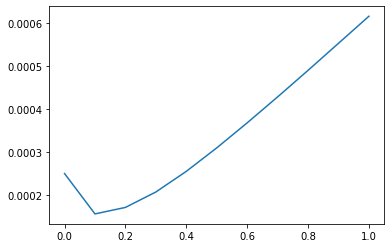

In [25]:
plt.plot(
    Alist[0].output['stats']['mean_z'],
    Alist[0].output['stats']['sigma_x']
)